In [12]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
library(biovizBase)
set.seed(1234)

ERROR: Error in library(biovizBase): there is no package called 'biovizBase'


In [6]:
counts <- Read10X_h5(filename = "/SGRNJ06/randd/PROJECT/scATAC/20230427_downsamle_sc/Downsample10X/run/downsample_L230321014XA/outs/filtered_peak_bc_matrix.h5")
metadata <- read.csv(
  file = "/SGRNJ06/randd/PROJECT/scATAC/20230427_downsamle_sc/Downsample10X/run/downsample_L230321014XA/outs/singlecell.csv",
  header = TRUE,
  row.names = 1
)

chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  genome = 'hg19',
  fragments = '/SGRNJ06/randd/PROJECT/scATAC/20230427_downsamle_sc/Downsample10X/run/downsample_L230321014XA/outs//fragments.tsv.gz',
  #min.cells = 10,
  #min.features = 200
)

pbmc <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


In [ ]:
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)
seqlevelsStyle(annotations) <- 'UCSC'
Annotation(pbmc) <- annotations

In [14]:
# compute nucleosome signal score per cell
pbmc <- NucleosomeSignal(object = pbmc)

# compute TSS enrichment score per cell
pbmc <- TSSEnrichment(object = pbmc, fast = FALSE)

# add blacklist ratio and fraction of reads in peaks
pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100
pbmc$blacklist_ratio <- pbmc$blacklist_region_fragments / pbmc$peak_region_fragments

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



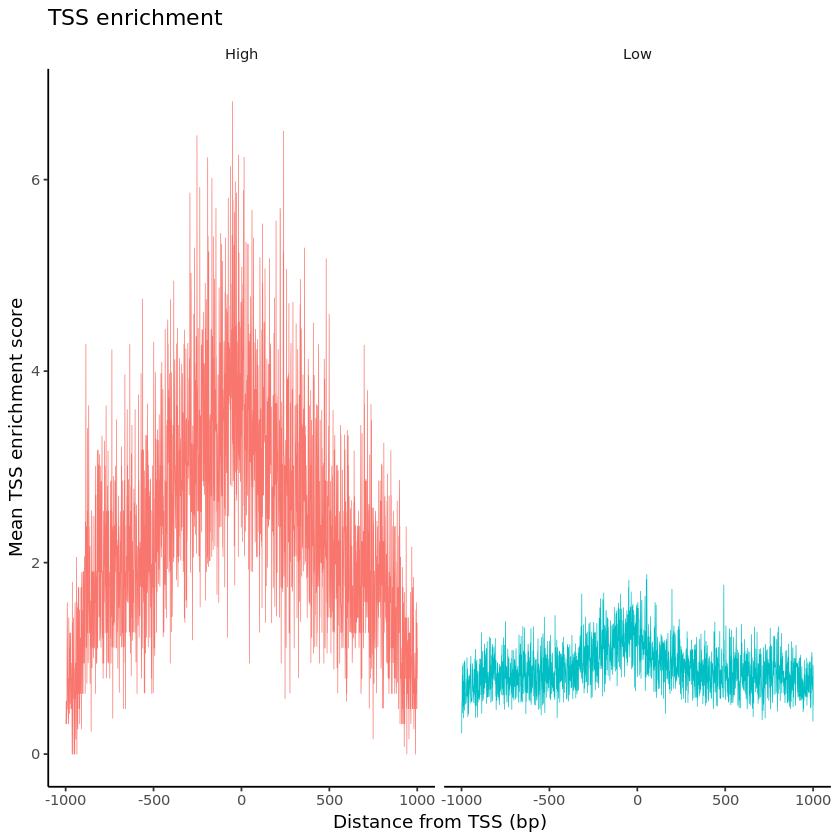

In [15]:
pbmc$high.tss <- ifelse(pbmc$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(pbmc, group.by = 'high.tss') + NoLegend()

Warning message:
"Removed 2 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 2 rows containing missing values (geom_bar)."


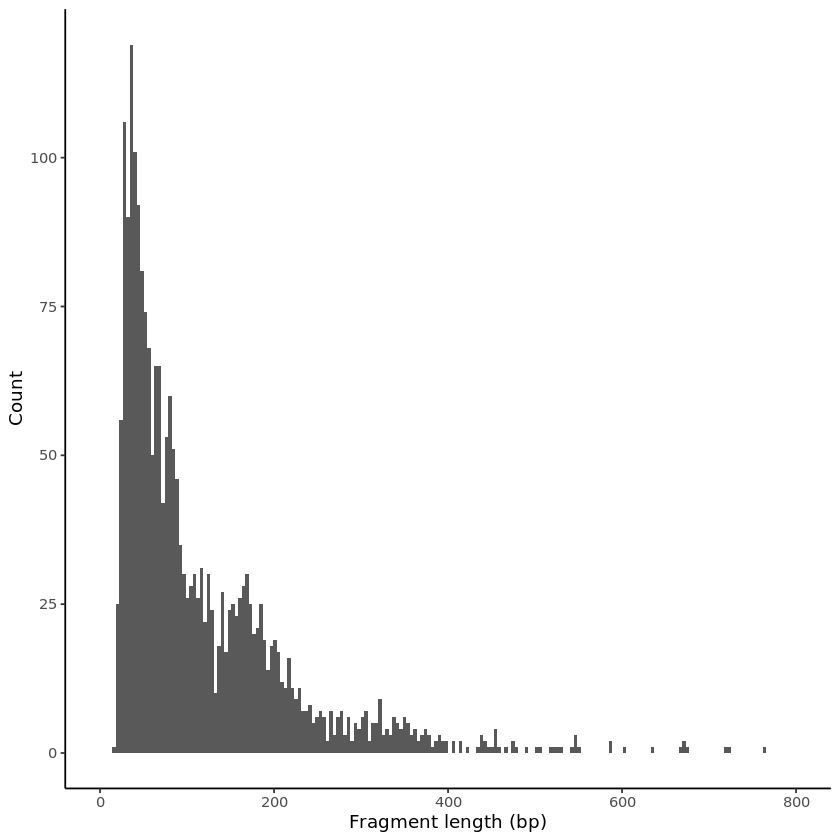

In [16]:
pbmc$nucleosome_group <- ifelse(pbmc$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
FragmentHistogram(object = pbmc, group.by = 'nucleosome_group')

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of blacklist_ratio."


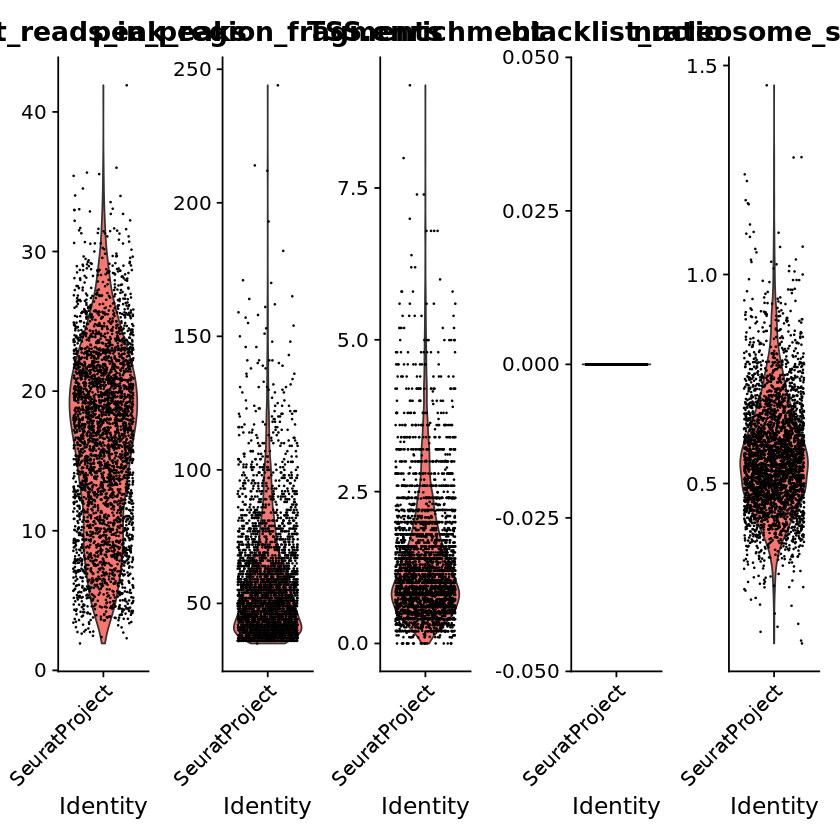

In [17]:
VlnPlot(
  object = pbmc,
  features = c('pct_reads_in_peaks', 'peak_region_fragments',
               'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5
)

In [18]:
pbmc <- subset(
  x = pbmc,
  subset = peak_region_fragments > 3000 &
    peak_region_fragments < 20000 &
    pct_reads_in_peaks > 15 &
    blacklist_ratio < 0.05 &
    nucleosome_signal < 4 &
    TSS.enrichment > 2
)
pbmc

ERROR: Error: No cells found


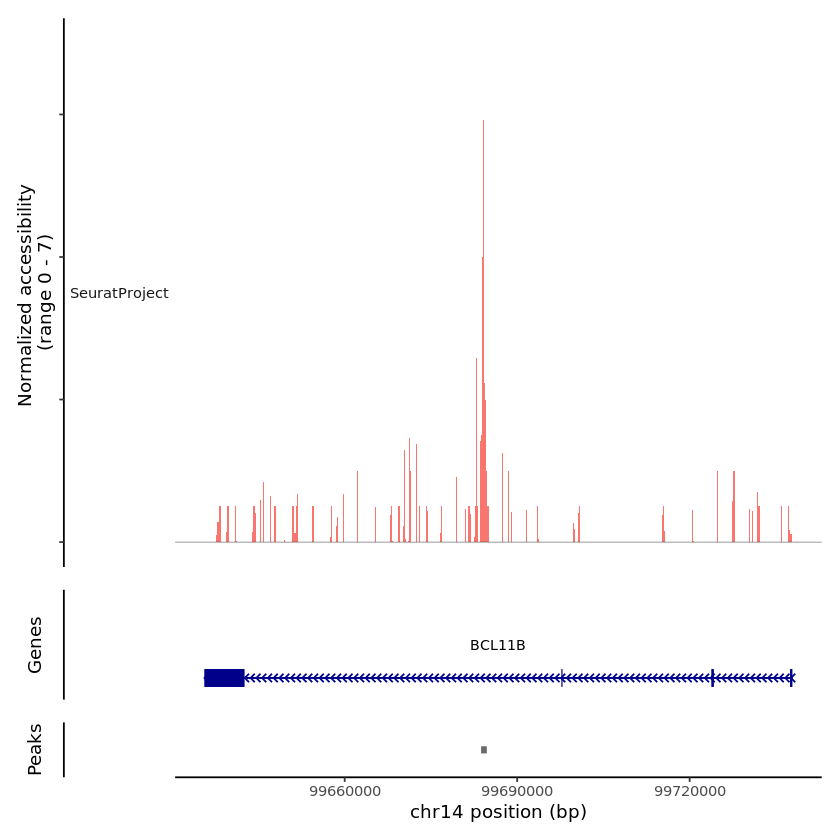

In [21]:
CoveragePlot(
  object = pbmc,
  region = "BCL11B"
)

In [22]:
levels(pbmc)

[1] "SeuratProject"